In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

import qulacs
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CNOT, CZ, RX, RY, RZ, merge
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
from qulacsvis import circuit_drawer

from openfermion.ops import QubitOperator
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from pyscf import fci

In [6]:
basis = "sto-3g"
multiplicity = 1
charge = 0
description  = "tmp"

def molecule(r):
    geometry = [["H", [0,0,0]],["H", [0,0,r]]]
    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    n_qubit = molecule.n_qubits
    n_electron = molecule.n_electrons
    fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
    jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
    qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))
    
    return n_qubit, qulacs_hamiltonian, jw_hamiltonian

In [7]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    circuit = QuantumCircuit(n_qubit)
    for i in range(n_qubit):
        circuit.add_gate(merge(RX(i, theta_list[2*i+3*n_qubit*depth]), RZ(i, theta_list[2*i+1+3*n_qubit*depth])))
    for d in range(depth):
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
        for i in range(n_qubit):
            circuit.add_gate(merge(merge(RZ(i, theta_list[2*i+3*n_qubit*d]), RX(i, theta_list[2*i+1+3*n_qubit*d])),RZ(i, theta_list[2*i+3*n_qubit*d])))
    
    return circuit

In [9]:
def cost_fun(theta_list, n_qubit, depth, hamiltonian):
    state = QuantumState(n_qubit)
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list)
    circuit.update_quantum_state(state)
    return hamiltonian.get_expectation_value(state)

In [19]:
number = 31
r_initial = 0.165
r_final = 4.0
r_list = []
energies = []
opt_theta_list = []

method = "BFGS"
options = {"gtol": 1e-8}
#options = {"disp": True, "gtol": 1e-6}

init_theta_list = 2*np.pi*np.random.random(3*molecule(0.5)[0]*molecule(0.5)[0]+2*molecule(0.5)[0])

for i in tqdm(range(number)):
    r = r_initial+i*(r_final-r_initial)/(number-1)
    n_qubit = molecule(r)[0]
    depth = n_qubit
    hamiltonian = molecule(r)[1]
    
    opt = minimize(lambda theta: cost_fun(theta, n_qubit, depth, hamiltonian), init_theta_list, method=method, options=options)
    
    r_list.append(r)
    opt_theta_list.append(opt.x)
    energies.append(opt.fun)


100%|██████████| 31/31 [03:36<00:00,  6.97s/it]


In [21]:
print(energies)

[0.6811919177017658, -0.5678283000959605, -0.953012062343138, -1.0917291385804015, -1.1339894290583556, -1.1337604307600575, -1.1147914628350617, -1.0881686564917643, -1.059484757610778, -1.0319914251475066, -1.0076479036340729, -0.9874299982645482, -0.9715346506295364, -0.9596152787423685, -0.95102628726197, -0.9450324199026141, -0.9409509046129543, -0.938221196932503, -0.9364190795820886, -0.932081753583682, -0.9324925485187241, -0.9327525056929553, -0.9329149753933483, -0.9330151772120334, -0.933076133041877, -0.9331127069252996, -0.9331343576437026, -0.9331470093090576, -0.9331543117143334, -0.9331584773140165, -0.9331608267620102]


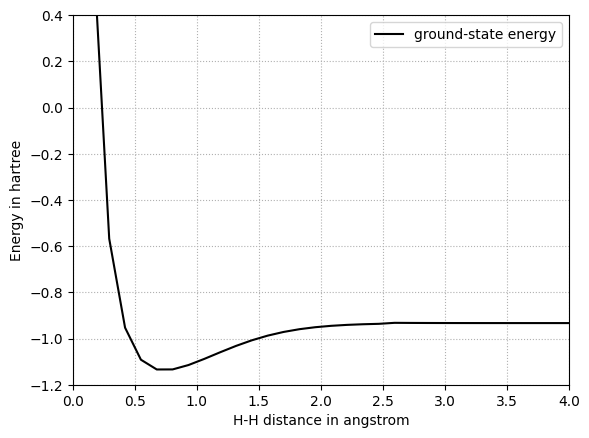

In [20]:
xmin_plot, xmax_plot = 0, 4
ymin_plot, ymax_plot = -1.2, 0.4
plt.xlim(xmin_plot, xmax_plot)
plt.ylim(ymin_plot, ymax_plot)

plt.plot(r_list, energies, color="black", linestyle="solid", label="ground-state energy")

plt.ylabel("Energy in hartree")
plt.xlabel("H-H distance in angstrom")
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

In [22]:
from qulacs.state import inner_product

def cost_fun_ex(theta_list, n_qubit, depth, hamiltonian):
    state_g = QuantumState(n_qubit)
    circuit_g = he_ansatz_circuit(n_qubit, depth, opt_theta_list[3])
    circuit_g.update_quantum_state(state_g)
    state = QuantumState(n_qubit)
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list)
    circuit.update_quantum_state(state)
    return hamiltonian.get_expectation_value(state) + 4*abs(inner_product(state_g, state))**2

In [24]:
number = 31
r_initial = 0.165
r_final = 4.0
energies_ex = []
opt_theta_ex_list = []

method = "BFGS"
options = {"gtol": 1e-8}

init_theta_list = 2*np.pi*np.random.random(3*molecule(0.5)[0]*molecule(0.5)[0]+2*molecule(0.5)[0])

for i in tqdm(range(number)):
    r = r_initial+i*(r_final-r_initial)/(number-1)
    n_qubit = molecule(r)[0]
    depth = n_qubit
    hamiltonian = molecule(r)[1]
    
    opt = minimize(lambda theta: cost_fun_ex(theta, n_qubit, depth, hamiltonian), init_theta_list, method=method, options=options)
    
    opt_theta_ex_list.append(opt.x)
    energies_ex.append(opt.fun)

100%|██████████| 31/31 [04:08<00:00,  8.01s/it]


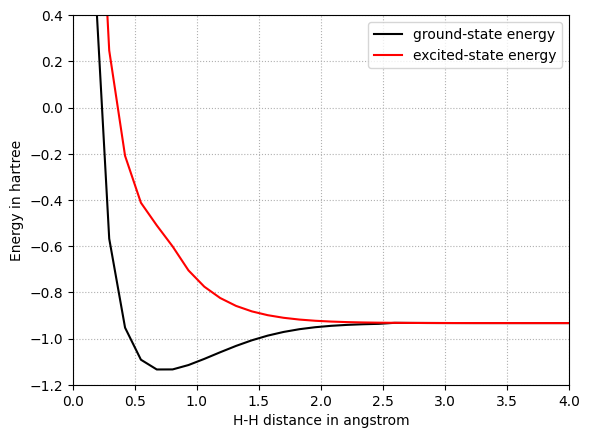

In [25]:
xmin_plot, xmax_plot = 0, 4
ymin_plot, ymax_plot = -1.2, 0.4
plt.xlim(xmin_plot, xmax_plot)
plt.ylim(ymin_plot, ymax_plot)

plt.plot(r_list, energies, color="black", linestyle="solid", label="ground-state energy")
plt.plot(r_list, energies_ex, color="red", linestyle="solid", label="excited-state energy")

plt.ylabel("Energy in hartree")
plt.xlabel("H-H distance in angstrom")
plt.grid(linestyle='dotted')
plt.legend()
plt.show()